In [24]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix


In [ ]:
##Cargar los datos
ruta_archivo = '../examen_datascience_fundamentals/data/diabetes.csv'
df = utils.cargar_datos(ruta_archivo)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



1. Limpieza de Datos:

* Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
* Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
* Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
* Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.


In [26]:
##Exploracion incial
measures = utils.exploracion_inicial(df)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Estadisticas del dataset
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531    

En el siguiente dataset se puede verificar que contamos con 768 registros con 9 columnas de features. En cuanto a las estadisticas descriptivas podemos ver que varias variables tienen un minimo valor de 0, lo cual fisiologicamente no es posible, esto indica que podrian tratarse de datos faltantes. Esto se presenta en features como glucose, bloodpreassure, skinthickness, insuline, BMI. Hay una alta desviacion estandar para variables como Insulin y BMI lo que sugiere presencia de outliers.

In [27]:
na_df = utils.identificar_valores_faltantes(df)
print(na_df)
utils.verificacion_elementos_duplicados(df)

Valores faltantes en el dataset
                          datos sin NAs en q  Na en q  Na en %
Pregnancies                              768        0      0.0
Glucose                                  768        0      0.0
BloodPressure                            768        0      0.0
SkinThickness                            768        0      0.0
Insulin                                  768        0      0.0
BMI                                      768        0      0.0
DiabetesPedigreeFunction                 768        0      0.0
Age                                      768        0      0.0
Outcome                                  768        0      0.0
Cantidad de filas duplicadas:  0


No se encuentran valores nulos, duplicados o con caracteres no numericos. Sin embargo, los 0 detectados en algunas variables sugieren datos faltantes.


2. Exploración de Datos:

* Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
* Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.


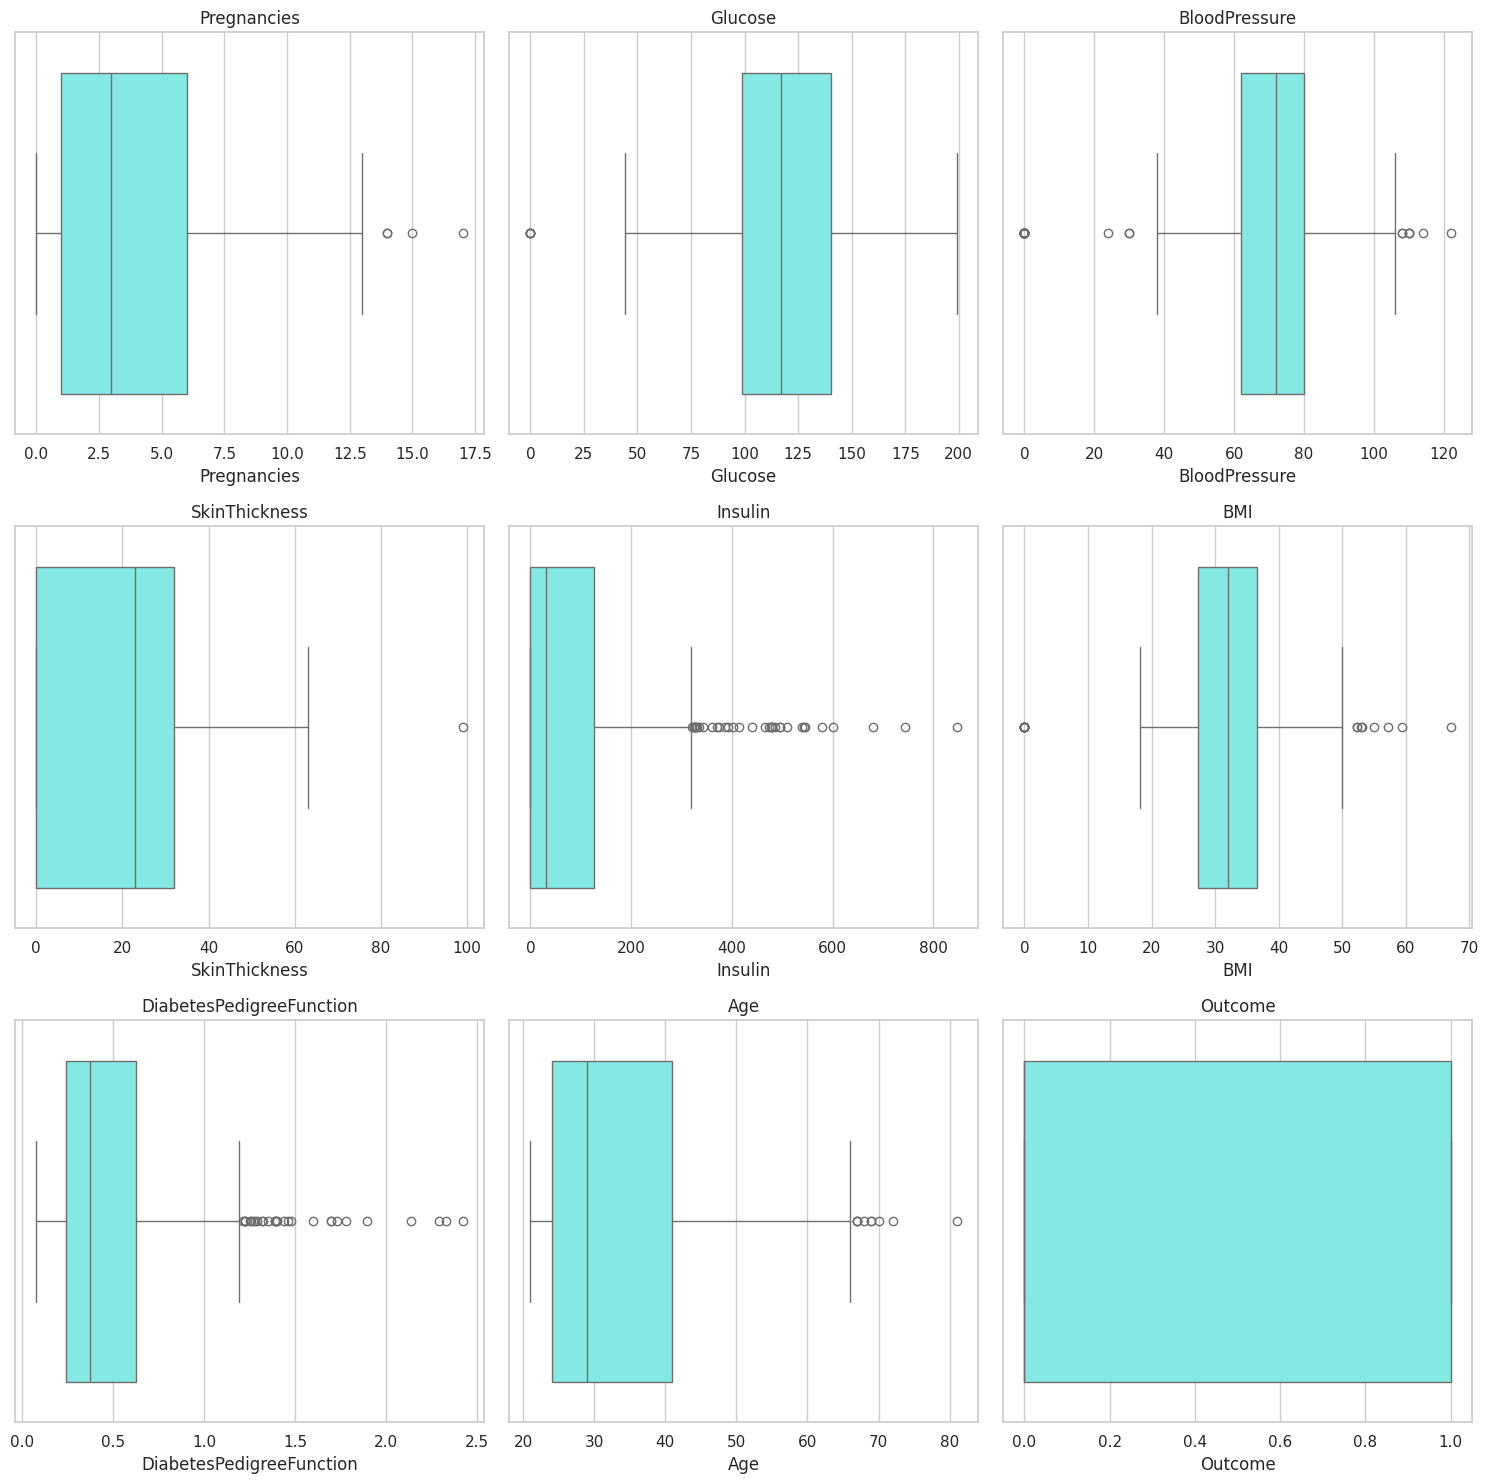

In [28]:
num_features = df.select_dtypes(include=['int64', 'float64'])
utils.plot_grafico_outliers(num_features,3,3,df)

En el grafico se puede verificar varias variables con valores atipicos o outliers, al tratarse de una clasificacion y ademas que no contamos con la suficiente cantidad de datos no podemos simplemente eliminarlos. En este caso, podrian tratarse de datos medicos que por su caracteristica extrema, pueden representar diabetes por lo que se procedera a escalar los valores de modo a no afectar el entrenamiento. Sin embargo, para los casos de variables con alto numeros de 0 puede representar la no carga de los datos, los cuales debemos imputar para corregir los mmismos.

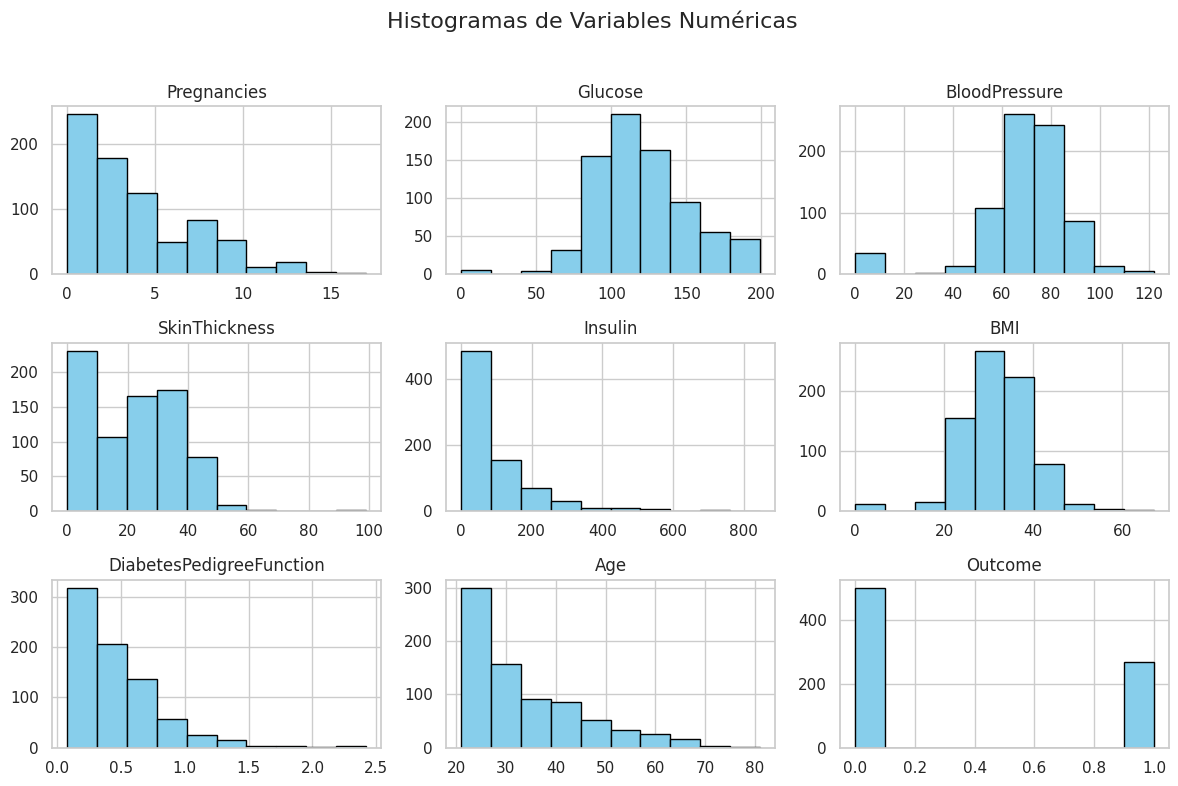

In [29]:
# Configuración general de los gráficos
sns.set(style="whitegrid")

#Histogramas (Univariados)

df.hist(bins=10, figsize=(12, 8), color='skyblue', edgecolor='black')

plt.suptitle("Histogramas de Variables Numéricas", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


Lo que se puede observar en estos graficos univariados es que las variables se encuentran sesgados por algunas variables como por ejemplo el target hay mas datos con valores 0 que 1. Aqui se deja una descripcion de cada grafico.
* Pregnancies: La mayoría de las pacientes tienen entre 1 y 5 embarazos, aunque hay un número significativo de mujeres con más embarazos. La distribución parece estar ligeramente sesgada hacia la derecha.
* Glucose: Los niveles de glucosa muestran una distribución más dispersa, con un pico alrededor de los 100 mg/dl. Sin embargo, hay un número considerable de pacientes con niveles de glucosa significativamente más altos.
* BloodPressure: La presión arterial se concentra principalmente en un rango entre 60 y 80 mmHg, pero también hay valores más altos y algunos más bajos.
* SkinThickness: La distribución de este indicador es bastante dispersa, con muchos valores bajos y algunos muy altos.
* Insulin: Los niveles de insulina muestran una gran variabilidad, con muchos valores bajos y algunos muy altos. La distribución parece ser bastante sesgada hacia la derecha.
* BMI: El índice de masa corporal se concentra principalmente en un rango entre 20 y 30, lo que corresponde a un peso normal o sobrepeso.
* DiabetesPedigreeFunction: Esta variable muestra una distribución bastante sesgada hacia la izquierda, con la mayoría de los valores concentrados en un rango bajo.
* Age: La edad de las pacientes se distribuye de manera más uniforme, con una mayor concentración en las edades medias.
* Outcome: Esta variable, que indica la presencia o ausencia de diabetes, es binaria y por lo tanto no se representa de la misma manera que las variables numéricas continuas.

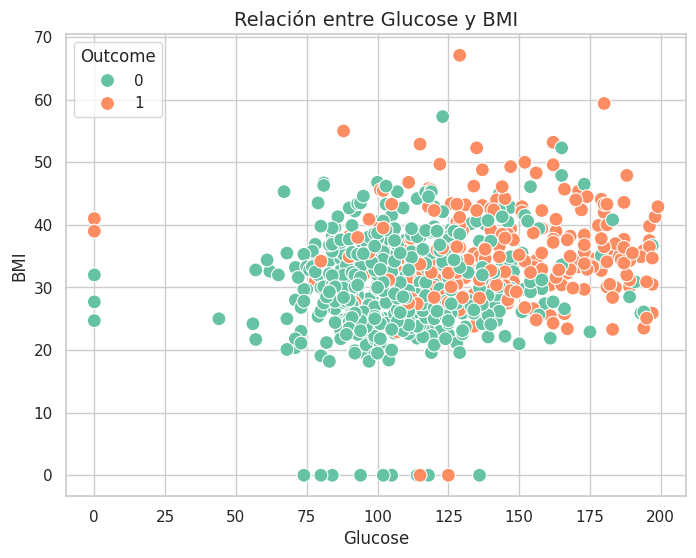

In [30]:
#Diagrama de dispersión (Multivariado): Glucose vs. BMI, coloreado por Outcome

plt.figure(figsize=(8, 6))

sns.scatterplot(data=df, x="Glucose", y="BMI", hue="Outcome", palette="Set2", s=100)

plt.title("Relación entre Glucose y BMI", fontsize=14)

plt.xlabel("Glucose")

plt.ylabel("BMI")

plt.show()


Este grafico muestra la relacion entre la glucosa, el indice de masa corporal (IMC) y la presencia de diabetes. Por lo que se puede observar en este grafico, hay una relacion positiva entre los niveles de glucosa y el IMC. Por lo tanto, niveles altos de glucosa e IMC son factores de riesgo asociados con la diabetes.

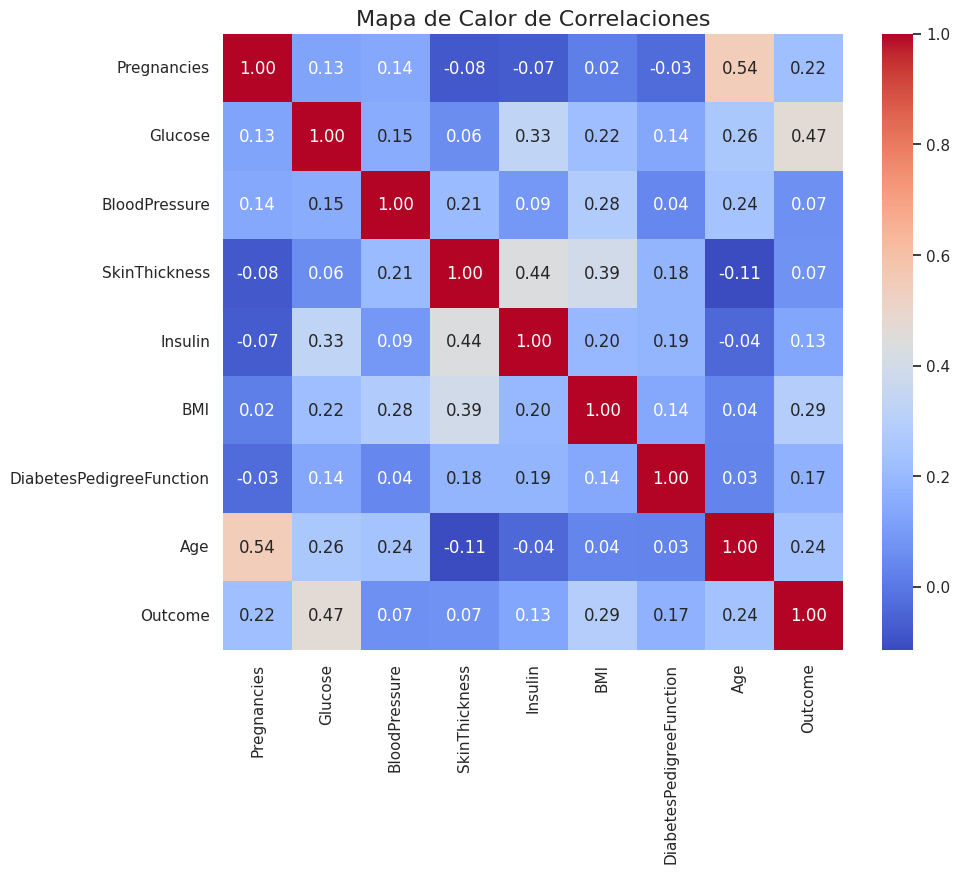

In [31]:
# Mapa de calor de correlación (Multivariado)

plt.figure(figsize=(10, 8))

correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Mapa de Calor de Correlaciones", fontsize=16)

plt.show()

En este grafico de correlaciones muestra que hay una alta correlacion positiva entre la glucosa y el outcome 0.47, las demas variables no representan correlaciones importantes con el outcome. Sin embargo, se puede observar tambien una relacion positiva importante entre edad y embarazo que es lo logico, asi como tambien algunos como glucosa e insulina, edad y glucosa pero no tan significativos para el modelo.


3. Implementación de Modelos:

* Modelos de Clasificación: Implementa modelos de Random Forest y XGBoost.
* Evaluación de Modelos: Evalúa los modelos utilizando métricas como accuracy, precision, recall, F1-score, y ROC-AUC.
* Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.


In [32]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#### Debido a que se encuentran valores 0 para algunas variables y estas son variables medicas se procede a imputar los valores 0 de acuerdo a la distribucion de las mimas. Es decir, se considerara la media para las variables que tienen una distribucion normal y mediana para los que no tienen distribucion normal.

In [33]:
# Asumiendo el diccionario de las estadisticas descriptivas resultantes de utils
# y verificando si la distribucion es normal a traves del check_normality en utils
#Comprobaremos si las columnas tienen una distribucion normal o no para imputar de acuerdo al mismo
## Codigo desarrollado con ayuda de chatgpt
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:  ##Columnas con valores 0 presentes
       is_normal = utils.check_normality(X_train, col)
       if is_normal:
          # Impute with mean if available, otherwise use column mean
          mean_value = measures[col].get('Mean', X_train[col].mean()) # Get 'Mean' or calculate if missing
          X_train[col] = X_train[col].replace(0, mean_value)
          X_test[col] = X_test[col].replace(0, mean_value)
       else:
          # Impute with median if available, otherwise use column median
          median_value = measures[col].get('median', X_train[col].median()) # Get 'median' or calculate if missing
          X_train[col] = X_train[col].replace(0, median_value)
          X_test[col] = X_test[col].replace(0, median_value)

In [34]:
### Escalamos los valores numericos
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names

# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


In [35]:
# Modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_transformed, y_train)

# Predicciones con Random Forest
y_pred_rf = rf_model.predict(X_test_transformed)

# Modelo XGBoost
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42) #Se utiliza la metrica de evaluacion logloss ya es mejor para casos de clase binarias como este caso
xgb_model.fit(X_train_transformed, y_train)

# Predicciones con XGBoost
y_pred_xgb = xgb_model.predict(X_test_transformed)

# Evaluar los modelos
rf_metrics = classification_report(y_test, y_pred_rf, output_dict=True)
xgb_metrics = classification_report(y_test, y_pred_xgb, output_dict=True)

# Mostrar accuracy de ambos modelos
rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)


In [36]:
# Calcular métricas para Random Forest

rf_precision = rf_metrics["1"]["precision"]
rf_recall = rf_metrics["1"]["recall"]
rf_f1 = rf_metrics["1"]["f1-score"]
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calcular métricas para XGBoost
xgb_precision = xgb_metrics["1"]["precision"]
xgb_recall = xgb_metrics["1"]["recall"]
xgb_f1 = xgb_metrics["1"]["f1-score"]
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])


# Consolidar métricas
evaluation_results = {
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [rf_accuracy, xgb_accuracy],
    "Precision": [rf_precision, xgb_precision],
    "Recall": [rf_recall, xgb_recall],
    "F1-Score": [rf_f1, xgb_f1],
    "ROC-AUC": [rf_auc, xgb_auc],
}

pd.DataFrame(evaluation_results)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.818182,0.711111,0.680851,0.695652,0.692384
1,XGBoost,0.798701,0.648148,0.744681,0.693069,0.486677


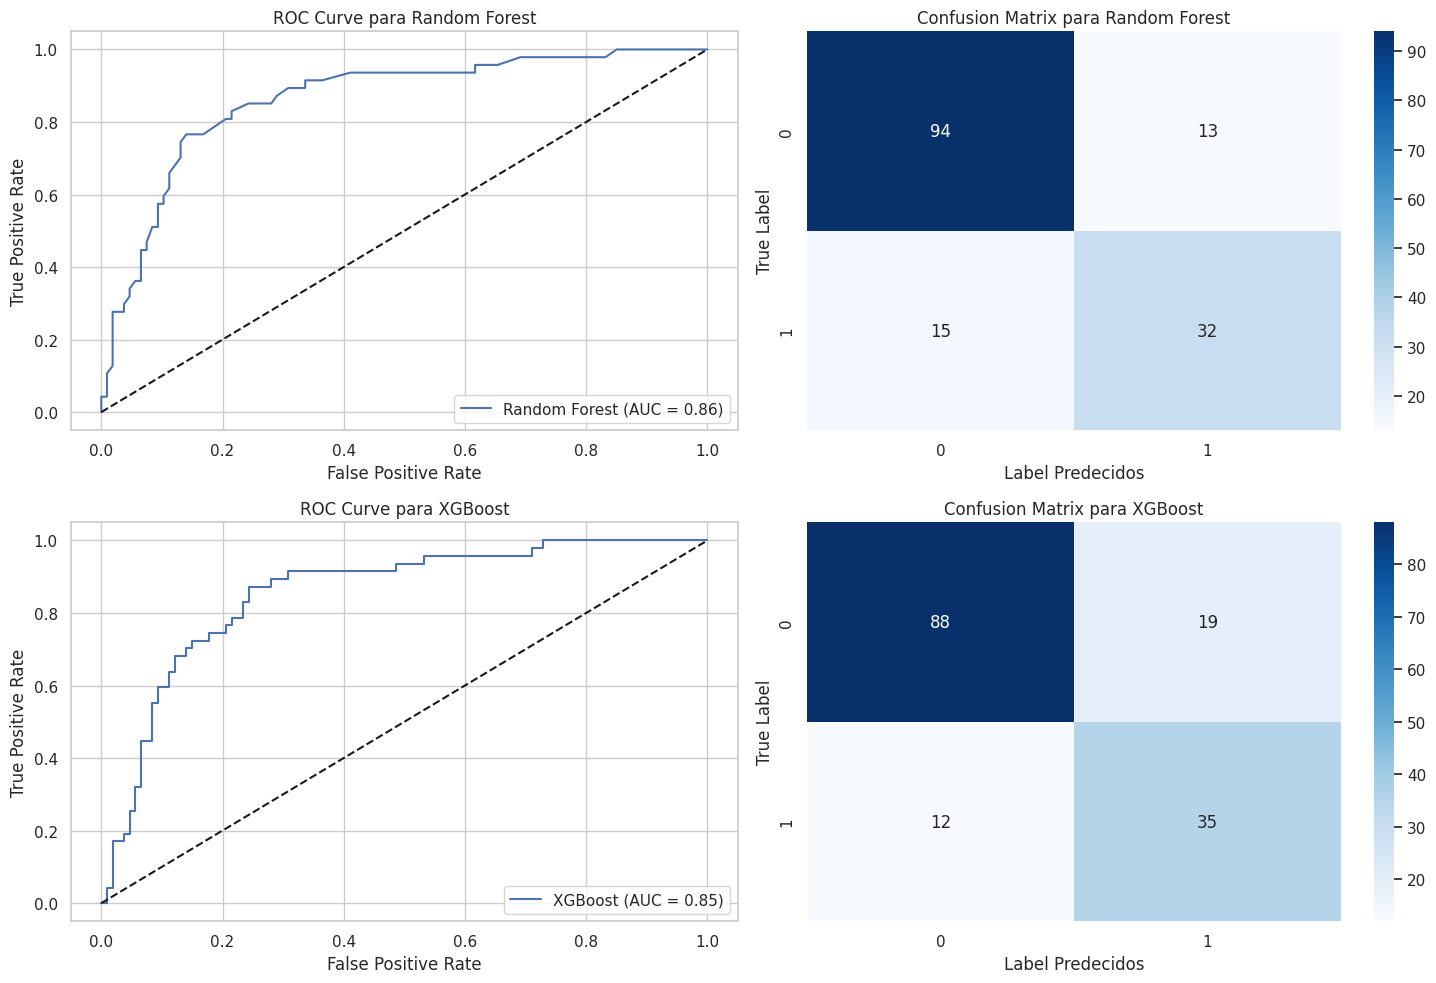

In [37]:
def plot_roc_auc_confusion_matrix(models, model_names, X_test, y_test):

    fig, axes = plt.subplots(len(models), 2, figsize=(15, len(models) * 5))  # Create subplots

    for i, model in enumerate(models):
        # ROC-AUC Curva
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de clase positivas
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        axes[i, 0].plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')
        axes[i, 0].plot([0, 1], [0, 1], 'k--')  # Diagonal line
        axes[i, 0].set_xlabel('False Positive Rate')
        axes[i, 0].set_ylabel('True Positive Rate')
        axes[i, 0].set_title(f'ROC Curve para {model_names[i]}')
        axes[i, 0].legend(loc="lower right")

        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 1])
        axes[i, 1].set_xlabel('Label Predecidos')
        axes[i, 1].set_ylabel('True Label')
        axes[i, 1].set_title(f'Confusion Matrix para {model_names[i]}')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have models stored in a list called 'models' and their names in 'model_names'
models = [rf_model, xgb_model]
model_names = ["Random Forest", "XGBoost"]
plot_roc_auc_confusion_matrix(models, model_names, X_test_transformed, y_test)

### Conclusiones finales y comparacion de rendimiento de modelos

- Comparacion de modelos
1. Random Forest:
  1.1 Resultados del modelo:
    * Accuracy: 81.82%, ligeramente superior a XGBoost.
    * Precision: 71.11%, lo que indica que el modelo tiene un buen manejo de los falsos positivos.
    * Recall: 68.09%, un poco más bajo, lo que sugiere que algunos casos positivos no fueron correctamente identificados.
    * F1-Score: 69.56%, balance entre precisión y sensibilidad.
    * ROC-AUC: 69.24%, indicando una capacidad moderada para distinguir entre clases.

2. XGBoost:

    * Accuracy: 79.87%, un poco menor que Random Forest.
    * Precision: 64.81%, menos precisa que Random Forest en la predicción de positivos.
    * Recall: 74.47%, mejor que Random Forest en detectar casos positivos.
    * F1-Score: 69.31%, similar a Random Forest.
    * ROC-AUC: 48.67%, significativamente más bajo, lo que sugiere que el modelo no distingue adecuadamente entre las clases.

3. Resultado graficos:

    * La curva ROC para Random Forest tiene un área más amplia (AUC = 0.86) en comparación con XGBoost (AUC = 0.85). Esto representa que Random Forest tiene una capacidad superior para separar clases.
    * Las matrices de confusión muestran que:
    * Random Forest tiene menos falsos negativos (15 frente a 12 de XGBoost) pero más falsos positivos.
    * XGBoost detecta más positivos correctamente, pero lo hace a costa de aumentar los falsos positivos.

Conclusion final Random Forest parece ser un modelo mas equilibrado para la deteccion de diabetes, con mejor precision general y manejo decente de falsos positivos y negativos. XGBoost tiene mejor recall, pero bajas metricas en otras en especial ROC-AUC, lo que hace que este modelo sea menos confiable para esta tarea con un dataset medico.